Importing the Dataset

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Importing libraries

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.applications.densenet import DenseNet201
import matplotlib.pyplot as plt

In [6]:
import numpy as np

In [7]:
import cv2
from PIL import Image, ImageFilter

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

Splitting the dataset

In [8]:
from sklearn.model_selection import train_test_split
import os
from shutil import copyfile

# Assume you have a directory containing your images, and each class has its own subdirectory
data_dir = "/content/Dataset3.0"

# Specify your output directories for the training and testing sets
train_dir = "/content/Train"
test_dir = "/content/Test"

# Create the output directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each class in the dataset
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    # Use train_test_split to split the images for each class
    train_images, test_images = train_test_split(os.listdir(class_path), test_size=0.3, random_state=42)

    # Copy the training images to the training set directory
    for img in train_images:
        src_path = os.path.join(class_path, img)
        image = Image.open(src_path)
        image = image.convert('RGB')
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        dst_path = os.path.join(train_dir, class_name, img)
        image.save(dst_path)

    # Copy the testing images to the testing set directory
    for img in test_images:
        src_path = os.path.join(class_path, img)
        image = Image.open(src_path)
        image = image.convert('RGB')
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        dst_path = os.path.join(test_dir, class_name, img)
        image.save(dst_path)

Image Specification

In [1]:
IMG_HEIGHT = 480
IMG_WIDTH = 640
SEED = 123   #defines randomness in each batch
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2  #splitting of  validation testing from training

In [2]:
def plot_images(train_ds, class_names):

  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(1):
    for i in range(12):
      ax = plt.subplot(4, 4, i+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

def batch_shape(train_ds):
  for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [3]:
#function plot graphs for the validation and accuracy, arc stands for architecture
def plot_graph(history, arc_name):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('{} Training and Validation Accuracy'.format(arc_name))

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('{} Training and Validation Loss'.format(arc_name))
  plt.xlabel('epoch')
  plt.show()

### MobileNetV2

In [10]:
#data loader
train_ds_mn2 = keras.utils.image_dataset_from_directory(
    directory = "/content/Train",
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
    seed=SEED,
)
val_ds_mn2 = keras.utils.image_dataset_from_directory(
    directory = "/content/Train",
    label_mode="int",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    validation_split=VALIDATION_SPLIT,
    interpolation="bilinear",
    subset="validation",
    seed=SEED,
)


Found 2464 files belonging to 10 classes.
Using 1972 files for training.
Found 2464 files belonging to 10 classes.
Using 492 files for validation.


In [13]:
def apply_box_blur(image, radius):
    return image.filter(ImageFilter.BoxBlur(radius))

In [14]:
import os

directory = '/content/Test/QRS Party'

for filename in os.listdir(directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = Image.open(os.path.join(directory, filename))
        blurred_image = apply_box_blur(image, 5)
        blurred_image.save(os.path.join(directory, 'blurred_' + filename))

In [23]:
directory = '/content/Train/TUV Party'

for filename in os.listdir(directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image = Image.open(os.path.join(directory, filename))
        blurred_image = apply_box_blur(image, 5)
        blurred_image.save(os.path.join(directory, 'blurred_' + filename))

In [30]:
test_ds_mn2 = keras.utils.image_dataset_from_directory(
    directory = "/content/Test",
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation="bilinear",
    seed=SEED,
)

Found 1056 files belonging to 10 classes.


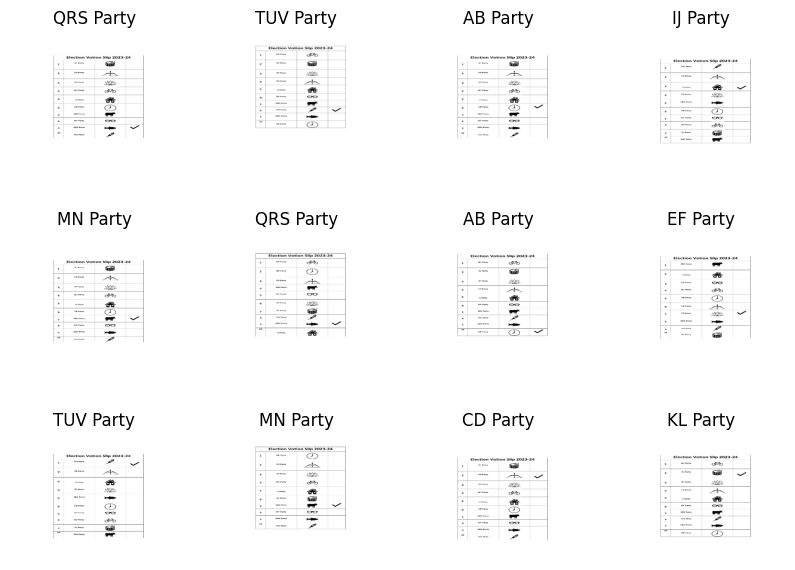

In [11]:
class_names_mn2 = train_ds_mn2.class_names
plot_images(train_ds_mn2, class_names_mn2)

In [12]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mn2_preprocess

In [19]:
# def preprocess_mn2(image, label):
#   image /= 255.0
#   image = (image * 2.0) - 1.0
#   return image, label

# train_ds_mn2 = train_ds_mn2.map(preprocess_mn2)
# val_ds_mn2 = val_ds_mn2.map(preprocess_mn2)
# test_ds_mn2 = test_ds_mn2.map(preprocess_mn2)

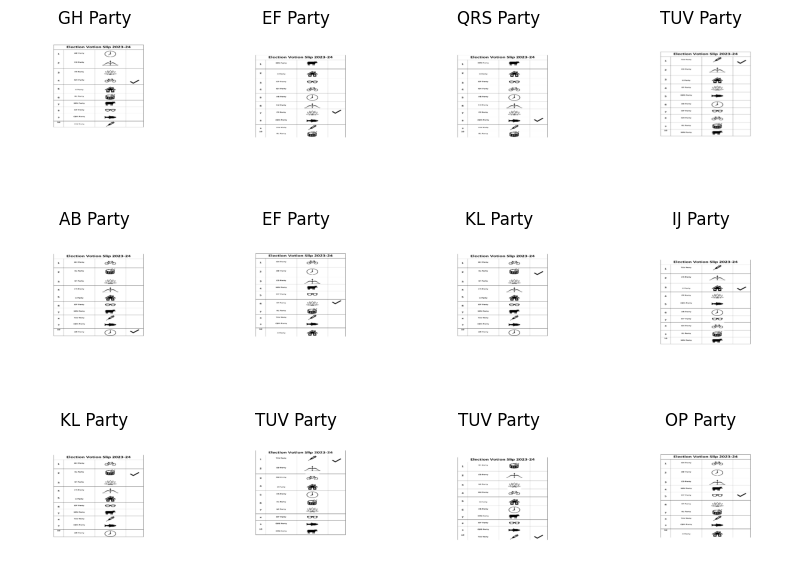

In [13]:
plot_images(train_ds_mn2, class_names_mn2)

In [14]:
mn2_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
)
mn2_base.trainable = False
mn2_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 480, 640, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 240, 320, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 240, 320, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 240, 320, 32)         0         ['bn_Conv1[

In [15]:
image_batch, label_batch = next(iter(train_ds_mn2))
feature_batch = mn2_base(image_batch)
print(feature_batch.shape)

(32, 15, 20, 1280)


In [16]:
model_mn2 = Sequential([
    mn2_base,
    Flatten(),
    layers.Dense(units=1000, activation='relu'),
    layers.Dense(units=800, activation='relu'),
    layers.Dropout(rate=0.1),
    layers.Dense(units=300, activation='relu'),
    layers.Dense(units=100, activation='relu'),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=10, activation='softmax'),
])

In [17]:
model_mn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 15, 20, 1280)      2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 384000)            0         
                                                                 
 dense (Dense)               (None, 1000)              384001000 
                                                                 
 dense_1 (Dense)             (None, 800)               800800    
                                                                 
 dropout (Dropout)           (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               240300    
                                                        

Epoch 1/15
62/62 [==============================] - 98s 1s/step - loss: 2.0719 - accuracy: 0.2662 - val_loss: 1.7580 - val_accuracy: 0.3130
Epoch 2/15
62/62 [==============================] - 88s 1s/step - loss: 1.4541 - accuracy: 0.4787 - val_loss: 1.3351 - val_accuracy: 0.5163
Epoch 3/15
62/62 [==============================] - 90s 1s/step - loss: 1.1398 - accuracy: 0.5913 - val_loss: 0.9760 - val_accuracy: 0.6260
Epoch 4/15
62/62 [==============================] - 87s 1s/step - loss: 0.8110 - accuracy: 0.6902 - val_loss: 0.5621 - val_accuracy: 0.8171
Epoch 5/15
62/62 [==============================] - 88s 1s/step - loss: 0.6561 - accuracy: 0.7551 - val_loss: 0.5167 - val_accuracy: 0.8211
Epoch 6/15
62/62 [==============================] - 90s 1s/step - loss: 0.4920 - accuracy: 0.8043 - val_loss: 0.4267 - val_accuracy: 0.8008
Epoch 7/15
62/62 [==============================] - 91s 1s/step - loss: 0.4222 - accuracy: 0.8423 - val_loss: 0.4879 - val_accuracy: 0.8455
Epoch 8/15
62/62 [==

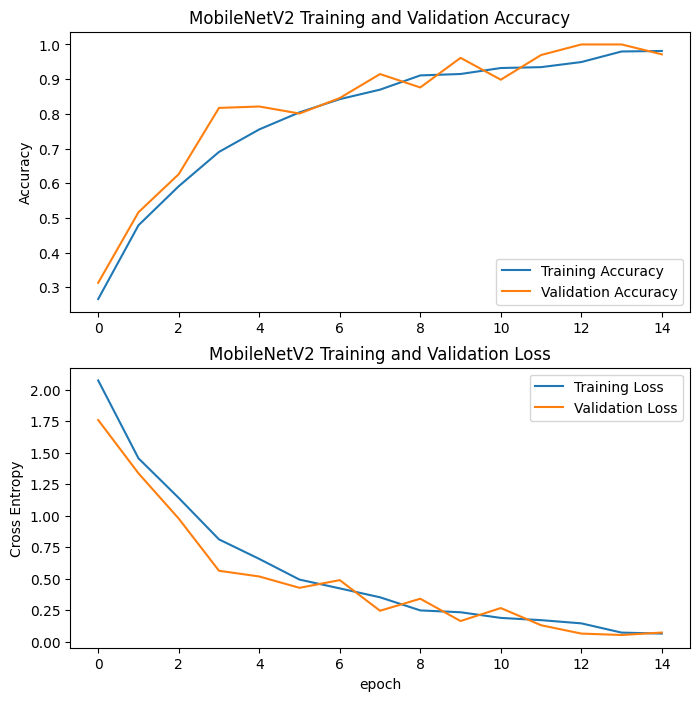

28min 22s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
%%timeit -n1 -r1
opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8)
model_mn2.compile(optimizer=opt,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
epochs=15
history_mn2 = model_mn2.fit(train_ds_mn2, validation_data=val_ds_mn2, epochs=epochs, verbose=True)
plot_graph(history_mn2, "MobileNetV2")

In [19]:
plot_images(test_ds_mn2, class_names_mn2)

NameError: ignored

In [20]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Live Input (not effective yet)

<IPython.core.display.Javascript object>

Saved to photo.jpg


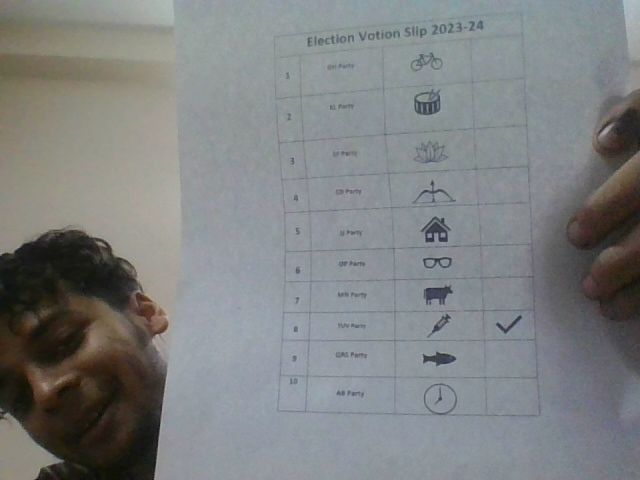

In [21]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [31]:
# Load the image
image = Image.open('/content/photo.jpg')

# Get the image size
width, height = image.size

# Get the image format
format = image.format

# Get the image mode
mode = image.mode

# Print the image size and details
print("Image size (width x height):", width, "x", height)
print("Image format:", format)
print("Image mode:", mode)

Image size (width x height): 640 x 480
Image format: JPEG
Image mode: RGB


In [22]:
test_ds_mn3 = keras.utils.image_dataset_from_directory(
    directory = "/content/Sample",
    batch_size=1,
    label_mode="int",
    shuffle=False,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation="bilinear",
    seed=SEED,
)

Found 2 files belonging to 1 classes.


In [23]:
zipp = zipfile.ZipFile('/content/drive/MyDrive/TestSample.zip', 'r')
zipp.extractall('/content/Sample/TUV Party')
zipp.close()

NameError: ignored

In [24]:
from keras.preprocessing.image import load_img, img_to_array

# Load the image from a file
image = load_img('/content/photo.jpg')
image = img_to_array(image)

# Add a batch dimension to the image array
image = np.expand_dims(image, axis=0)

# Resize the image to the expected input shape
resized_image = cv2.resize(image[0], (224, 224), interpolation=cv2.INTER_AREA)

In [37]:
image = image.astype('float32')
image /= 255
image = np.expand_dims(image, axis=0)

In [39]:
from keras.preprocessing.image import load_img, img_to_array

# Load the image from a file
image = load_img('/content/photo.jpg')
image = img_to_array(image)

# Reshape the image to the expected input shape
# image = image.reshape((1, 224, 224, 3))
predicted_labels=[]
true_labels=[]
for image_batch, label_batch in test_ds_mn2:
    true_labels.append(label_batch.numpy()[0])
    predicted_labels.append(np.argmax(model_mn2.predict(image_batch)))

print(predicted_labels)

1/1 [==============================] - 0s 170ms/step
[112, 164, 113, 21, 398, 333, 177, 372, 135, 268, 157, 398, 99, 294, 320, 268, 294, 47, 385, 411, 229, 8, 177, 112, 411, 229, 294, 216, 385, 14, 320, 268, 320]


In [25]:
answer = np.argmax(model_mn2.predict(test_ds_mn3))

2/2 [==============================] - 1s 16ms/step


In [28]:
for image, label in test_ds_mn3:
  print(class_names_mn2[np.argmax(model_mn2.predict(image))])

1/1 [==============================] - 0s 34ms/step
TUV Party
1/1 [==============================] - 0s 45ms/step
TUV Party


In [31]:
model_mn2.evaluate(test_ds_mn2)

33/33 [==============================] - 34s 837ms/step - loss: 0.7913 - accuracy: 0.8788


[0.7912641763687134, 0.8787878751754761]

In [66]:
print(class_names_mn2)

['AB Party', 'CD Party', 'EF Party', 'GH Party', 'IJ Party', 'KL Party', 'MN Party', 'OP Party', 'QRS Party', 'TUV Party']
